In [1]:
import hydra
from utils import load_config_and_model, load_config_and_model_tnpd
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
from src.model.utils import AttrDict
from src.dataset.latents.image_no_np import Image
import matplotlib.pyplot as plt

In [2]:
path = "results/discrete/trained/image/00-54-30/"
path_tnpd = "results/discrete/trained/image/01-07-40/"
config_path = path+".hydra/"

torch.manual_seed(45)

# Load ACE model and config
cfg, model = load_config_and_model(path, path + ".hydra/", 
                                   ckpt_name="ckpt_140000.tar")

# Load TNPD model and config
cfg_tnpd, model_tnpd = load_config_and_model_tnpd(path_tnpd, path_tnpd +".hydra/", 
                                                  ckpt_name="ckpt_140000.tar")

In [3]:
image = Image()
b_xyd, b_xyl = image.get_data() 

num_ctx = 10
ind = 7

/Users/changp1/Documents/2024/infMachine/code/src/model/embedder.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_discrete = torch.isin(batch.yc, torch.tensor(discrete_values)).float()
/Users/changp1/Documents/2024/infMachine/code/src/model/target_head.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_discrete = torch.isin(batch.yt, torch.tensor(discrete_values))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..2

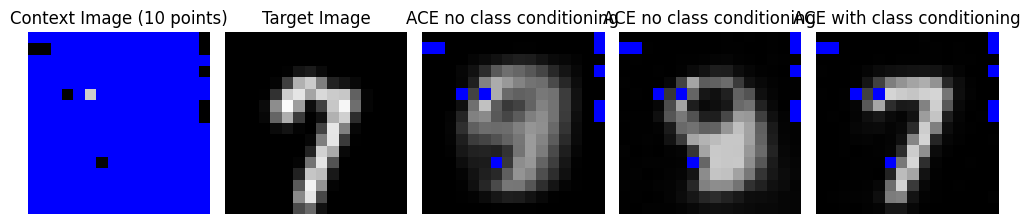

In [4]:
num_ctx = 10
ind = 10#1#7

xyc = b_xyd[:, :num_ctx, :]
xyt = b_xyd[:, num_ctx:, :] 

batch = AttrDict() 
batch.xc = copy.deepcopy(xyc[:, :, :-1])
batch.yc = copy.deepcopy(xyc[:, :, -1:])

batch.xt = copy.deepcopy(xyt[:, :, :-1])
batch.yt = copy.deepcopy(xyt[:, :, -1:])

xyc_latent = torch.concat((xyc, b_xyl), dim=1)

batch_l = AttrDict({
    'xc': xyc_latent[:, :, :-1],
    'yc': xyc_latent[:, :, -1:],
    'xt': xyt[:, :, :-1],
    'yt': xyt[:, :, -1:]
})

# First image
xc = (15 * batch.xc[ind, :, 1:3]).to(torch.long)
yc = batch.yc[ind, :, -1]
image_size = 16

im_context1 = np.zeros((image_size, image_size, 3))
im_context1[:, :, 2] = 1
im_context1[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()

# Second image
xt = (15 * batch.xt[ind, :, 1:3]).to(torch.long)
yt = batch.yt[ind, :, -1]
im_context2 = np.zeros((image_size, image_size, 3))
im_context2[:, :, 2] = 1
im_context2[xt[:, 0], xt[:, 1]] = yt.repeat(3, 1).transpose(0, 1).cpu()
im_context2[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()


#TNPD model
out_tnpd = model_tnpd.forward(batch, predict=True)
xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
yc = out_tnpd.mean[ind, :].detach().numpy()

im_context_tnpd = np.zeros((image_size, image_size, 3))
im_context_tnpd[:, :, 2] = 1
im_context_tnpd[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)
im_context_tnpd[0, 0] = 0

out = model.forward(batch, predict=True)
xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
#yc = out.mean[ind, :, -1]
yc = out.median[ind, :]
image_size = 16

im_context_nl = np.zeros((image_size, image_size, 3))
im_context_nl[:, :, 2] = 1
im_context_nl[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

out = model.forward(batch_l, predict=True)
xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
#yc = out.mean[ind, :, -1]
yc = out.median[ind, :]
image_size = 16

im_context_l = np.zeros((image_size, image_size, 3))
im_context_l[:, :, 2] = 1
im_context_l[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

# Plotting the images next to each other
fig, axs = plt.subplots(1, 5, figsize=(10, 5))

axs[0].imshow(im_context1)
axs[0].axis('off')  # Remove axis labels
axs[0].set_title('Context Image (10 points)')

axs[1].imshow(im_context2)
axs[1].axis('off')  # Remove axis labels
axs[1].set_title('Target Image')

axs[2].imshow(im_context_tnpd)
axs[2].axis('off')  # Remove axis labels
axs[2].set_title('ACE no class conditioning')

axs[3].imshow(im_context_nl)
axs[3].axis('off')  # Remove axis labels
axs[3].set_title('ACE no class conditioning')

axs[4].imshow(im_context_l)
axs[4].axis('off')  # Remove axis labels
axs[4].set_title('ACE with class conditioning')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


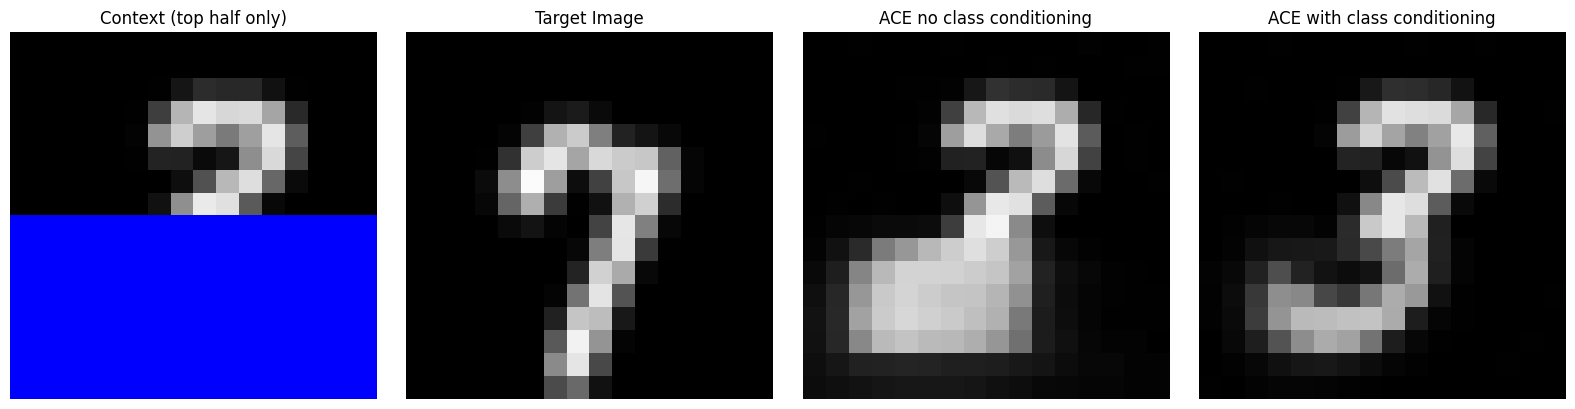

In [5]:
# im_context2[xt[:, 0], xt[:, 1]] = yt.repeat(3, 1).transpose(0, 1).cpu()
# im_context2[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()

ind = 2



xyc = b_xyd[:, :256, :]
xyt = b_xyd[:, 256:, :] 

batch = AttrDict() 
batch.xc = copy.deepcopy(xyc[:, :, :-1])
batch.yc = copy.deepcopy(xyc[:, :, -1:])

batch.xt = copy.deepcopy(xyc[:, :, :-1])
batch.yt = copy.deepcopy(xyc[:, :, -1:])



def mask_bottom_half(xc, yc):
    mask = xc[:, :, 1] < 0.5  # Mask points in the top half (y < 0.5)
    return xc[mask].view(xc.shape[0], -1, xc.shape[2]), yc[mask].view(yc.shape[0], -1, yc.shape[2])

# Create masked context
xc_masked, yc_masked = mask_bottom_half(batch.xc, batch.yc)

# Context image (top half only)
xc_plot = (15 * xc_masked[ind, :, 1:3]).to(torch.long)
yc_plot = yc_masked[ind, :, -1]
im_context_masked = np.zeros((image_size, image_size, 3))
im_context_masked[:, :, 2] = 1
im_context_masked[xc_plot[:, 0], xc_plot[:, 1]] = yc_plot.repeat(3, 1).transpose(0, 1).cpu()

# Generate predictions for masked data
batch_masked = AttrDict()
batch_masked.xc = xc_masked
batch_masked.yc = yc_masked
batch_masked.xt = batch.xt
batch_masked.yt = batch.yt

out_masked = model.forward(batch_masked, predict=True)
xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
yc_masked_pred = out_masked.median[ind]

im_context_nl_masked = np.zeros((image_size, image_size, 3))
im_context_nl_masked[:, :, 2] = 1
im_context_nl_masked[xc[:, 0], xc[:, 1]] = yc_masked_pred.repeat(3, 1).transpose(0, 1)

# Generate predictions for masked data with latent conditioning
batch_l_masked = AttrDict()
batch_l_masked.xc = torch.cat([xc_masked, b_xyl[:, :, :-1]], dim=1)
batch_l_masked.yc = torch.cat([yc_masked, b_xyl[:, :, -1:]], dim=1)
batch_l_masked.xt = batch.xt
batch_l_masked.yt = batch.yt

out_l_masked = model.forward(batch_l_masked, predict=True)
yc_l_masked_pred = out_l_masked.median[ind]

im_context_l_masked = np.zeros((image_size, image_size, 3))
im_context_l_masked[:, :, 2] = 1
im_context_l_masked[xc[:, 0], xc[:, 1]] = yc_l_masked_pred.repeat(3, 1).transpose(0, 1)


# Plotting the images
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(im_context_masked)
axs[0].axis('off')
axs[0].set_title('Context (top half only)')

axs[1].imshow(im_context2)
axs[1].axis('off')
axs[1].set_title('Target Image')

axs[2].imshow(im_context_nl_masked)
axs[2].axis('off')
axs[2].set_title('ACE no class conditioning')

axs[3].imshow(im_context_l_masked)
axs[3].axis('off')
axs[3].set_title('ACE with class conditioning')

plt.tight_layout()
plt.show()

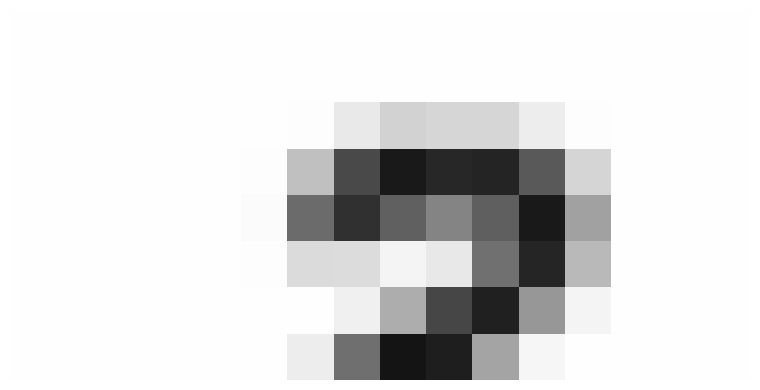

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming im_context_masked is your original image

# Get only the top half of the image
image_height, image_width, _ = im_context_masked.shape
top_half = im_context_masked[:image_height//2, :, :]

# Invert the colors manually
inverted_image = 1 - top_half  # This works for images in [0, 1] range

# If your image data is in [0, 255] range, use this instead:
# inverted_image = 255 - top_half

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Display the inverted image
ax.imshow(inverted_image)
ax.axis('off')
#fig.savefig('saved_img/toy_context_inverted.png', bbox_inches='tight', pad_inches=0)
ax.axis('off')
#fig.savefig('saved_img/im_context_nl_masked_inverted.png', bbox_inches='tight', pad_inches=0)
fig.savefig('saved_img/fig1_context.svg', format='svg')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


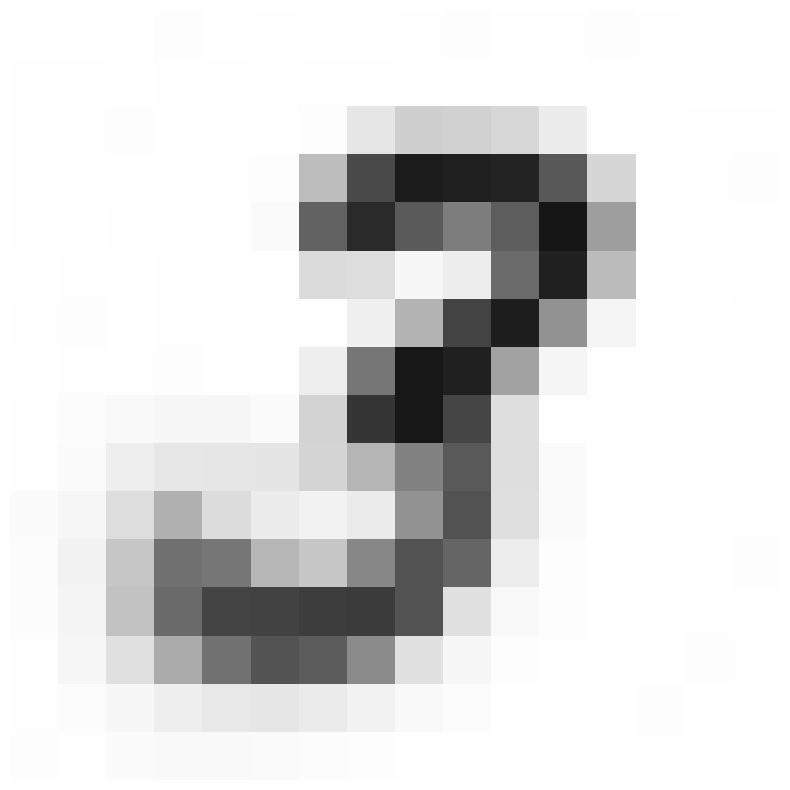

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming im_context_nl_masked is your original image

# Invert the colors manually
inverted_image = 1 - im_context_l_masked  # This works for images in [0, 1] range

# If your image data is in [0, 255] range, use this instead:
# inverted_image = 255 - im_context_nl_masked

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Display the inverted image
ax.imshow(inverted_image)
ax.axis('off')
#fig.savefig('saved_img/im_context_nl_masked_inverted.png', bbox_inches='tight', pad_inches=0)
fig.savefig('saved_img/fig1c.svg', format='svg')


plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


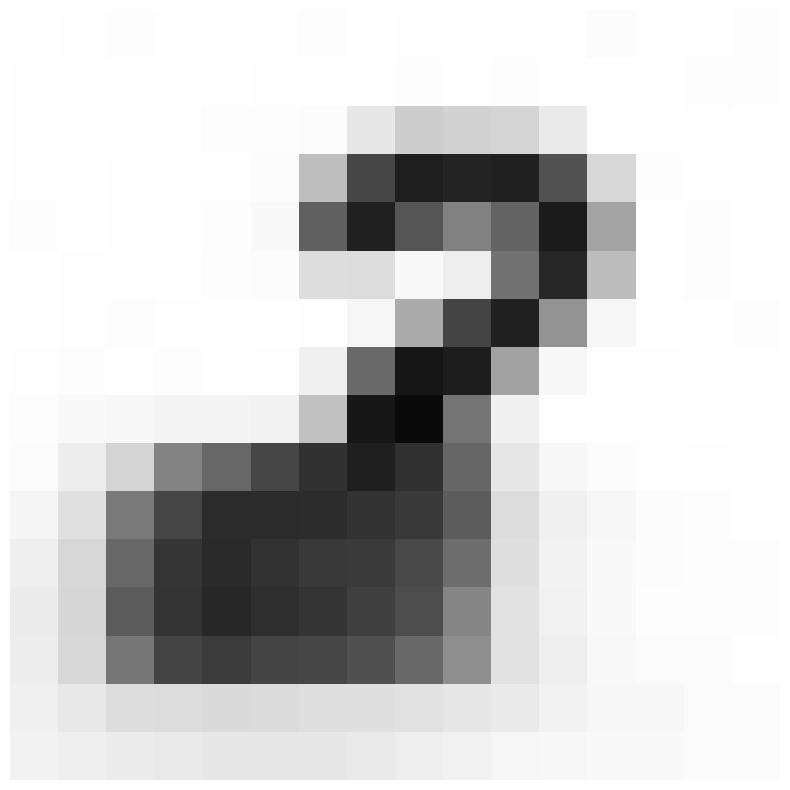

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming im_context_nl_masked is your original image

# Invert the colors manually
inverted_image = 1 - im_context_nl_masked  # This works for images in [0, 1] range

# If your image data is in [0, 255] range, use this instead:
# inverted_image = 255 - im_context_nl_masked

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Display the inverted image
ax.imshow(inverted_image)
ax.axis('off')
#fig.savefig('saved_img/im_context_nl_masked_inverted.png', bbox_inches='tight', pad_inches=0)
fig.savefig('saved_img/fig1a.svg', format='svg')


plt.tight_layout()
plt.show()

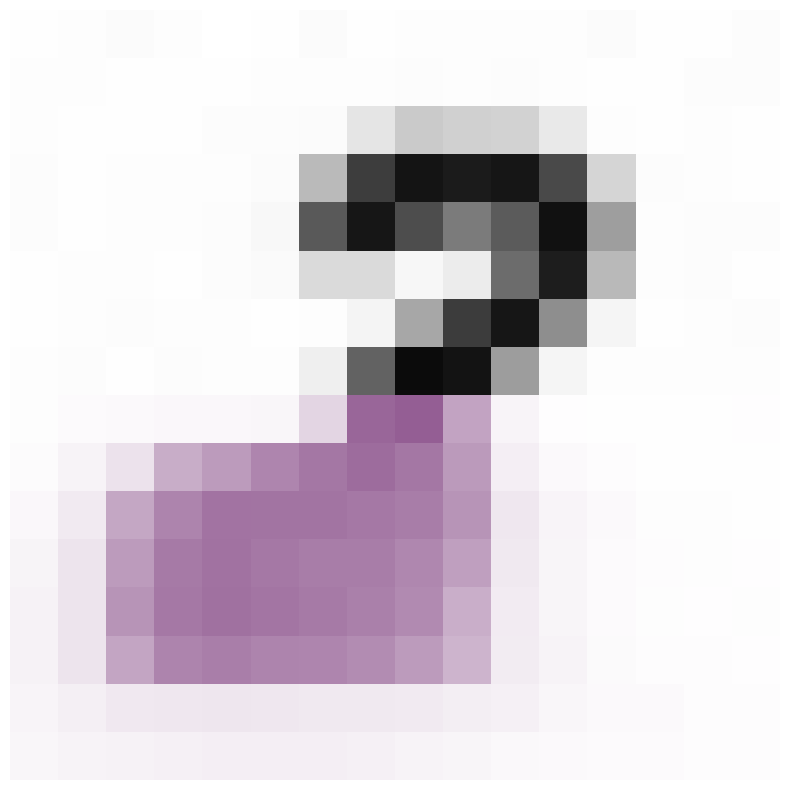

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming im_context_nl_masked is your original image for the top half
# and im_context_l_masked is your original image for the bottom half

# Normalize both images to ensure values are between 0 and 1
normalized_top = (im_context_nl_masked - im_context_nl_masked.min()) / (im_context_nl_masked.max() - im_context_nl_masked.min())
normalized_bottom = (im_context_nl_masked - im_context_nl_masked.min()) / (im_context_l_masked.max() - im_context_l_masked.min())

# Create slightly darker purple tint
purple_tint = np.array([0.6, 0.4, 0.6])  # Slightly darker RGB values for purple

height = normalized_top.shape[0]

# Prepare the top half (white figure on black background)
top_half = 1 - normalized_top

# Prepare the bottom half (purple figure on white background)
inverted_bottom = 1 - normalized_bottom
rgb_bottom = 1 - (1 - inverted_bottom) * (1 - purple_tint)

# Combine top and bottom halves
combined_image = np.concatenate((top_half[:height//2], rgb_bottom[height//2:]), axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Display the final image
ax.imshow(combined_image)
ax.axis('off')

# Save the figure as SVG
fig.savefig('saved_img/fig1c_combined_correct_slightly_darker_purple.svg', format='svg', bbox_inches='tight', pad_inches=0)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


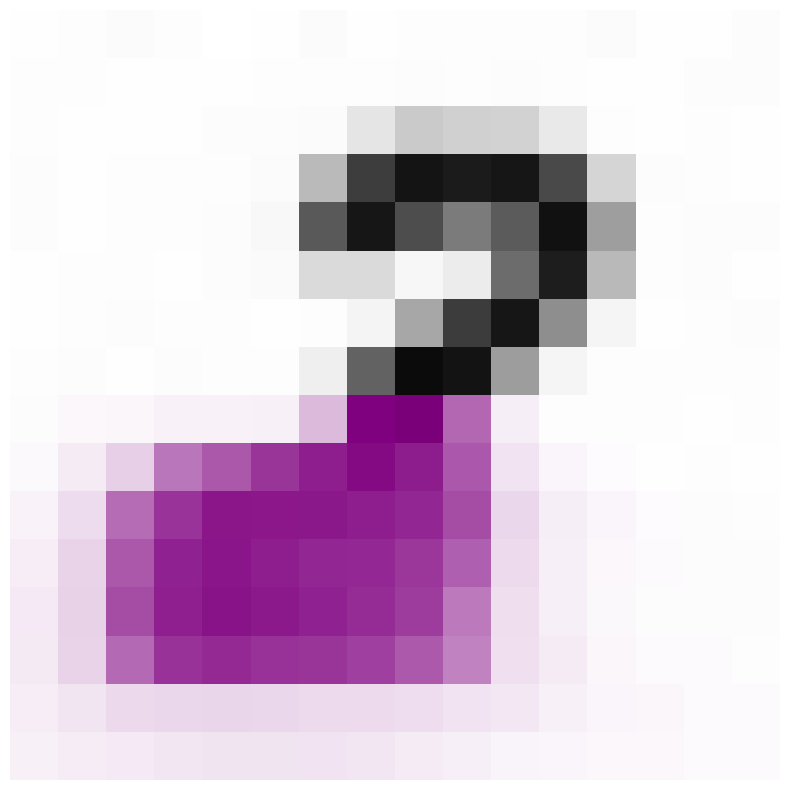

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming im_context_nl_masked is your original image for the top half
# and im_context_l_masked is your original image for the bottom half

# Normalize both images to ensure values are between 0 and 1
normalized_top = (im_context_nl_masked - im_context_nl_masked.min()) / (im_context_nl_masked.max() - im_context_nl_masked.min())
normalized_bottom = (im_context_nl_masked - im_context_nl_masked.min()) / (im_context_l_masked.max() - im_context_l_masked.min())

# Create purple tint
purple_tint = np.array([0.5, 0, 0.5])  # RGB values for purple

height = normalized_top.shape[0]

# Prepare the top half (white figure on black background)
top_half = 1 - normalized_top

# Prepare the bottom half (purple figure on white background)
inverted_bottom = 1 - normalized_bottom
rgb_bottom = 1 - (1 - inverted_bottom) * (1 - purple_tint)

# Combine top and bottom halves
combined_image = np.concatenate((top_half[:height//2], rgb_bottom[height//2:]), axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Display the final image
ax.imshow(combined_image)
ax.axis('off')

# Save the figure as SVG
fig.savefig('saved_img/fig1c_combined_correct.svg', format='svg', bbox_inches='tight', pad_inches=0)

plt.tight_layout()
plt.show()

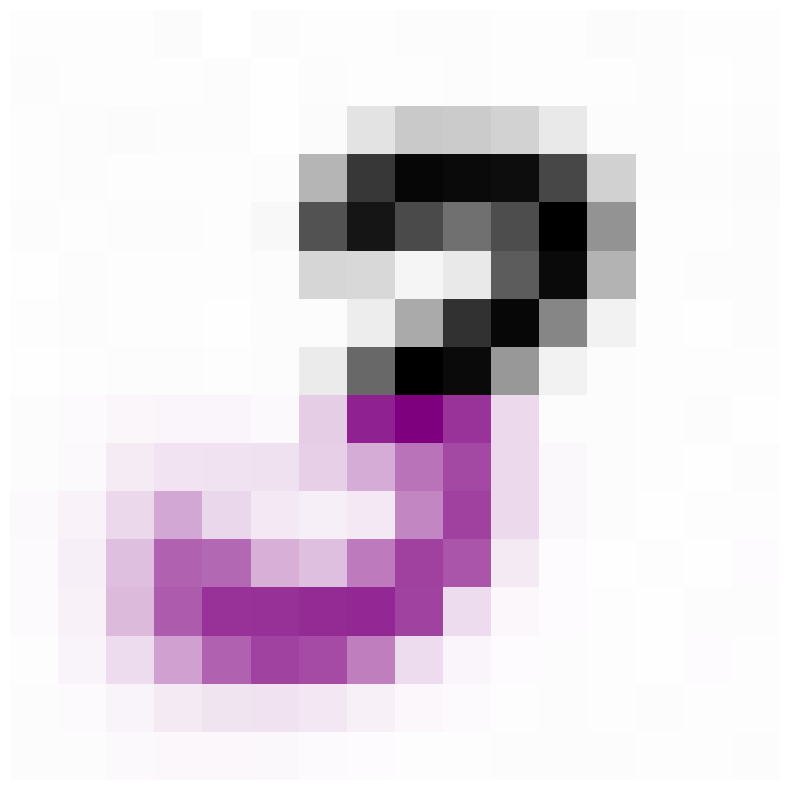

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming xc_masked, yc_masked, ind, and image_size are defined earlier in your code

xc_plot = (15 * xc_masked[ind, :, 1:3]).to(torch.long)
yc_plot = yc_masked[ind, :, -1]
im_context_masked = np.zeros((image_size, image_size, 3))
im_context_masked[:, :, 2] = 1
im_context_masked[xc_plot[:, 0], xc_plot[:, 1]] = yc_plot.repeat(3, 1).transpose(0, 1).cpu()

# Assuming im_context_l_masked is your original image with white background and dark digit

# Normalize the image to ensure values are between 0 and 1
normalized_image = (im_context_l_masked - im_context_l_masked.min()) / (im_context_l_masked.max() - im_context_l_masked.min())

# Create purple tint
purple_tint = np.array([0.5, 0, 0.5])  # RGB values for purple

height = normalized_image.shape[0]

# Prepare the top half (white figure on black background)
top_half = 1 - normalized_image[:height//2]

# Prepare the bottom half (purple figure on white background)
bottom_half = normalized_image[height//2:]
inverted_bottom = 1 - bottom_half
rgb_bottom = 1 - (1 - inverted_bottom) * (1 - purple_tint)

# Combine top and bottom halves
combined_image = np.concatenate((top_half, rgb_bottom), axis=0)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Display the final image
ax.imshow(combined_image)
ax.axis('off')

# Save the figure as SVG
fig.savefig('saved_img/fig1c_combined_correct.svg', format='svg', bbox_inches='tight', pad_inches=0)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['2', '3', '7']
values = [1, 1, 1]  # All bars have the same length

# Create the plot
# Enable XKCD style
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(6, 8))

    # Create the horizontal bar plot
    ax.barh(categories, values)

    # Customize the plot
    ax.set_xlim(0, 2.5)  # Set x-axis limits
    ax.set_xticks(range(4))  # Set x-axis ticks from 0 to 5
    #ax.set_xlabel('Value')
    #ax.set_ylabel('Category')
    #ax.set_title('Horizontal Bar Plot with Equal Lengths')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Invert y-axis to have 'A' at the top
    ax.invert_yaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.title('2 3 7 Probability')
    # Save the figure as SVG
    plt.tight_layout()
    plt.savefig('horizontal_bar_plot.svg', format='svg')

    # Show the plot
    plt.tight_layout()
    
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['0', '1', '2', '3', '4']
values = [1, 1, 1, 1, 1]  # All bars have the same length

# Enable XKCD style
with plt.xkcd():
    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 8))

    # Create the horizontal bar plot
    ax.barh(categories, values)

    # Customize the plot
    ax.set_xlim(0, 2.5)  # Set x-axis limits
    ax.set_xticks(range(4))  # Set x-axis ticks from 0 to 5
    ax.set_xlabel('Value')
    ax.set_ylabel('Category')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Invert y-axis to have '0' at the top
    ax.invert_yaxis()

    # Show the plot
    plt.tight_layout()

    plt.savefig('saved_img/xkcd_style_plot.pdf', format='pdf', bbox_inches='tight')

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['0', '1', '2', '3', '4']
values = [0.0, 0, 0, 3, 0]  # Two bars are higher

# Create the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Create the horizontal bar plot
ax.barh(categories, values)

# Customize the plot
ax.set_xlim(0, 2.5)  # Set x-axis limits
ax.set_xticks(range(4))  # Set x-axis ticks from 0 to 3
ax.set_xlabel('Value')
ax.set_ylabel('Category')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Invert y-axis to have '0' at the top
ax.invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Save each image separately as displayed by imshow
fig, ax = plt.subplots()
ax.imshow(im_context1)
ax.axis('off')
#ax.set_title("No hair latent")
fig.savefig('saved_img/mnist_im_context.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

fig, ax = plt.subplots()
ax.imshow(im_context2)
ax.axis('off')
#ax.set_title("No hair latent")
fig.savefig('saved_img/mnist_im_context_full.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

fig, ax = plt.subplots()
ax.imshow(im_context_tnpd)
ax.axis('off')
#ax.set_title("No hair latent")
fig.savefig('saved_img/mnist_im_context_tnpd.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

fig, ax = plt.subplots()
ax.imshow(im_context_nl)
ax.axis('off')
#ax.set_title("No hair latent")
fig.savefig('saved_img/mnist_im_context_nl.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

# Save each image separately as displayed by imshow
fig, ax = plt.subplots()
ax.imshow(im_context_l)
ax.axis('off')
#ax.set_title("No hair latent")
fig.savefig('saved_img/mnist_im_context_l.png', bbox_inches='tight', pad_inches=0)
plt.close(fig)

In [ ]:
#TNPD model
out_tnpd = model_tnpd.forward(batch, predict=True)
xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
yc = out_tnpd.mean[ind, :].detach().numpy()

im_context_tnpd = np.zeros((image_size, image_size, 3))
im_context_tnpd[:, :, 2] = 1
im_context_tnpd[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

In [ ]:

path = "results/discrete/trained/image/00-54-30/"
path_tnpd = "results/discrete/trained/image/01-07-40/"
config_path = path+".hydra/"

torch.manual_seed(45)

# Load ACE model and config
cfg, model = load_config_and_model(path, path + ".hydra/", 
                                   ckpt_name="ckpt_140000.tar")

# Load TNPD model and config
cfg_tnpd, model_tnpd = load_config_and_model_tnpd(path_tnpd, path_tnpd +".hydra/", 
                                                  ckpt_name="ckpt_140000.tar")


def generate_image(b_xyd, b_xyl, ind, num_ctx):
    xyc = b_xyd[:, :num_ctx, :]
    xyt = b_xyd[:, num_ctx:, :] 

    batch = AttrDict() 
    batch.xc = copy.deepcopy(xyc[:, :, :-1])
    batch.yc = copy.deepcopy(xyc[:, :, -1:])

    batch.xt = copy.deepcopy(xyt[:, :, :-1])
    batch.yt = copy.deepcopy(xyt[:, :, -1:])

    xyc_latent = torch.concat((xyc, b_xyl), dim=1)

    batch_l = AttrDict({
        'xc': xyc_latent[:, :, :-1],
        'yc': xyc_latent[:, :, -1:],
        'xt': xyt[:, :, :-1],
        'yt': xyt[:, :, -1:]
    })

    # First image
    xc = (15 * batch.xc[ind, :, 1:3]).to(torch.long)
    yc = batch.yc[ind, :, -1]
    image_size = 16

    im_context1 = np.zeros((image_size, image_size, 3))
    im_context1[:, :, 2] = 1
    im_context1[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()

    # Second image
    xc = (15 * batch.xt[ind, :, 1:3]).to(torch.long)
    yc = batch.yt[ind, :, -1]
    im_context2 = np.zeros((image_size, image_size, 3))
    im_context2[:, :, 2] = 1
    im_context2[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()

    out = model.forward(batch, predict=True)
    xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
    #yc = out.mean[ind, :, -1]
    yc = out.median[ind, :]
    image_size = 16

    im_context_nl = np.zeros((image_size, image_size, 3))
    im_context_nl[:, :, 2] = 1
    im_context_nl[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

    out = model.forward(batch_l, predict=True)
    xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
    #yc = out.mean[ind, :, -1]
    yc = out.median[ind, :]
    image_size = 16

    im_context_l = np.zeros((image_size, image_size, 3))
    im_context_l[:, :, 2] = 1
    im_context_l[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

    # Plotting the images next to each other
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))

    axs[0].imshow(im_context1)
    axs[0].axis('off')  # Remove axis labels
    axs[0].set_title('Context Image (10 points)')

    axs[1].imshow(im_context2)
    axs[1].axis('off')  # Remove axis labels
    axs[1].set_title('Target Image')

    axs[2].imshow(im_context_nl)
    axs[2].axis('off')  # Remove axis labels
    axs[2].set_title('ACE no class conditioning')

    axs[3].imshow(im_context_l)
    axs[3].axis('off')  # Remove axis labels
    axs[3].set_title('ACE with class conditioning')

    plt.tight_layout()
    plt.show()


image = Image()
b_xyd, b_xyl = image.get_data() 

num_ctx = 10
ind = 7
#generate_image(b_xyd, b_xyl, ind, num_ctx)

num_ctx = 20
ind = 15
#generate_image(b_xyd, b_xyl, ind, num_ctx)

ctx = [5, 10, 20, 30, 40, 50, 60, 70, 100, 150]
nlpd = np.zeros((len(ctx), 20))
nlpd_l = np.zeros((len(ctx), 20))
nlpd_tnpd = np.zeros((len(ctx), 20))

rmse = np.zeros((len(ctx), 20))
rmse_l = np.zeros((len(ctx), 20))

for j, num_ctx in enumerate(ctx):
    for i in range(20):    
        image = Image()
        b_xyd, b_xyl = image.get_data() 
        xyc = b_xyd[:, :num_ctx, :]
        xyt = b_xyd[:, num_ctx:, :] 

        batch = AttrDict() 
        batch.xc = copy.deepcopy(xyc[:, :, :-1])
        batch.yc = copy.deepcopy(xyc[:, :, -1:])

        batch.xt = copy.deepcopy(xyt[:, :, :-1])
        batch.yt = copy.deepcopy(xyt[:, :, -1:])

        model.eval()
        out = model.forward(batch, predict=True)

        med = out.median[:, :, None]
        square = (batch.yt[:,:,:] - med[:, :, :])**2

        rmse[j, i] = torch.mean(square).item()
        nlpd[j, i] = torch.mean(out.loss).item()

        # Prepare latent batches
        xyc_latent = torch.concat((xyc, b_xyl), dim=1)
        batch_l = AttrDict({
            'xc': xyc_latent[:, :, :-1],
            'yc': xyc_latent[:, :, -1:],
            'xt': xyt[:, :, :-1],
            'yt': xyt[:, :, -1:]
        })

        model.eval()
        out_l = model.forward(batch_l, predict=True)

        med = out_l.median[:, :, None]
        square = (batch.yt[:,:,:] - med[:, :, :])**2
        rmse_l[j, i] = torch.mean(square).item()
        nlpd_l[j, i] = torch.mean(out_l.loss).detach().numpy()

        model_tnpd.eval()
        out_tnpd = model_tnpd.forward(batch)
        nlpd_tnpd[j, i] = torch.mean(out_tnpd.loss).detach().numpy()

# Plot the NLPD
mean_nlpd = np.mean(nlpd, axis=1)
std_nlpd = np.std(nlpd, axis=1)

mean_nlpd_l = np.mean(nlpd_l, axis=1)
std_nlpd_l = np.std(nlpd_l, axis=1)

mean_nlpd_tnpd = np.mean(nlpd_tnpd, axis=1)
std_nlpd_tnpd = np.std(nlpd_tnpd, axis=1)

plt.errorbar(ctx, mean_nlpd, yerr=std_nlpd, fmt='-o', label='ACE no conditioning')
plt.errorbar(ctx, mean_nlpd_l, yerr=std_nlpd, fmt='-o',label='ACE conditioned class')
plt.errorbar(ctx, mean_nlpd_tnpd, yerr=std_nlpd, fmt='-o', label='TNPD')

plt.xlabel('Context Size')
plt.ylabel('NLPD')
plt.title('NLPD vs Context Size')
plt.legend(loc='best')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

ctx = [5, 10, 20, 30, 40, 50, 60, 70, 100, 150]
ctx_percentage = np.floor(np.array(ctx) / 256 * 100)

# Assuming nlpd, nlpd_l, and nlpd_tnpd are already defined
mean_nlpd = np.mean(nlpd, axis=1)
std_nlpd = np.std(nlpd, axis=1)

mean_nlpd_l = np.mean(nlpd_l, axis=1)
std_nlpd_l = np.std(nlpd_l, axis=1)

mean_nlpd_tnpd = np.mean(nlpd_tnpd, axis=1)
std_nlpd_tnpd = np.std(nlpd_tnpd, axis=1)

# Calculate 1.96 confidence intervals
conf_interval_nlpd = 1.96 * std_nlpd
conf_interval_nlpd_l = 1.96 * std_nlpd_l
conf_interval_nlpd_tnpd = 1.96 * std_nlpd_tnpd

# Plot with error bars and confidence bands
plt.plot(ctx_percentage, mean_nlpd, '-o', label='ACE no conditioning', markersize=3)
plt.fill_between(ctx_percentage, mean_nlpd - conf_interval_nlpd, mean_nlpd + conf_interval_nlpd, alpha=0.2)

plt.plot(ctx_percentage, mean_nlpd_l, '-o', label='ACE conditioned class', markersize=3)
plt.fill_between(ctx_percentage, mean_nlpd_l - conf_interval_nlpd_l, mean_nlpd_l + conf_interval_nlpd_l, alpha=0.2)

plt.plot(ctx_percentage, mean_nlpd_tnpd, '-o', label='TNPD', markersize=3)
plt.fill_between(ctx_percentage, mean_nlpd_tnpd - conf_interval_nlpd_tnpd, mean_nlpd_tnpd + conf_interval_nlpd_tnpd, alpha=0.2)

# Corrected xlabel to display percentage of the image
#plt.xlabel('Context Size (% of Image)')
plt.ylabel('NLPD')
#plt.title('NLPD vs Context Size')
plt.ylim(-1.8, 0)
plt.legend(loc='best')
tikzplotlib.save('plots/mnist_nlpd.tex', axis_width="\\figurewidth", axis_height="\\figureheight")
plt.show()

